# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
#!pip install --proxy proxy-eu.shell.com progressbar2

In [2]:
#!pip install --proxy proxy-eu.shell.com sklearn

In [3]:
#!pip install --proxy proxy-eu.shell.com lightgbm

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn import preprocessing
from sklearn.preprocessing import  StandardScaler,OneHotEncoder


from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import  MiniBatchKMeans, KMeans
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression 
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib

from sklearn.neighbors import KNeighborsClassifier 

from ast import literal_eval
import time
import progressbar
from scipy import stats
from pre_fit import pre_fit
import pickle
import xgboost as xgb


# magic word for producing visualizations in notebook
%matplotlib inline

C:\Users\Peter.Evah\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
%%time
# load in the data
azdias = pd.read_csv('azdias.csv', sep=';')
customers = pd.read_csv('customers.csv', sep=';')

'''
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

MAILOUT_TRAIN = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
MAILOUT_TEST = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

azdias.to_csv('azdias.csv', sep=';')
customers.to_csv('customers.csv', sep=';')

MAILOUT_TRAIN.to_csv('MAILOUT_TRAIN.csv', sep=';')
MAILOUT_TEST.to_csv('MAILOUT_TESTcsv', sep=';')
'''

original_azdias = azdias
original_customers = customers

<string>:2: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.


Wall time: 36.5 s


In [6]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
azdias.shape

(891221, 367)

In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 2.4+ GB


In [9]:
azdias.describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486465,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [10]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
customers.shape

(191652, 370)

In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 370 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(8)
memory usage: 541.0+ MB


In [13]:
customers.describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95825.500000,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,0.000000,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47912.750000,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95825.500000,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143738.250000,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191651.000000,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### Data Preprocessing

#### Evaluate Missing Data in Columns

In [14]:
# identify null data in dataset

azdias_null_sum = azdias.isnull().sum()
azdias_null_ratio = azdias_null_sum / len(azdias) * 100

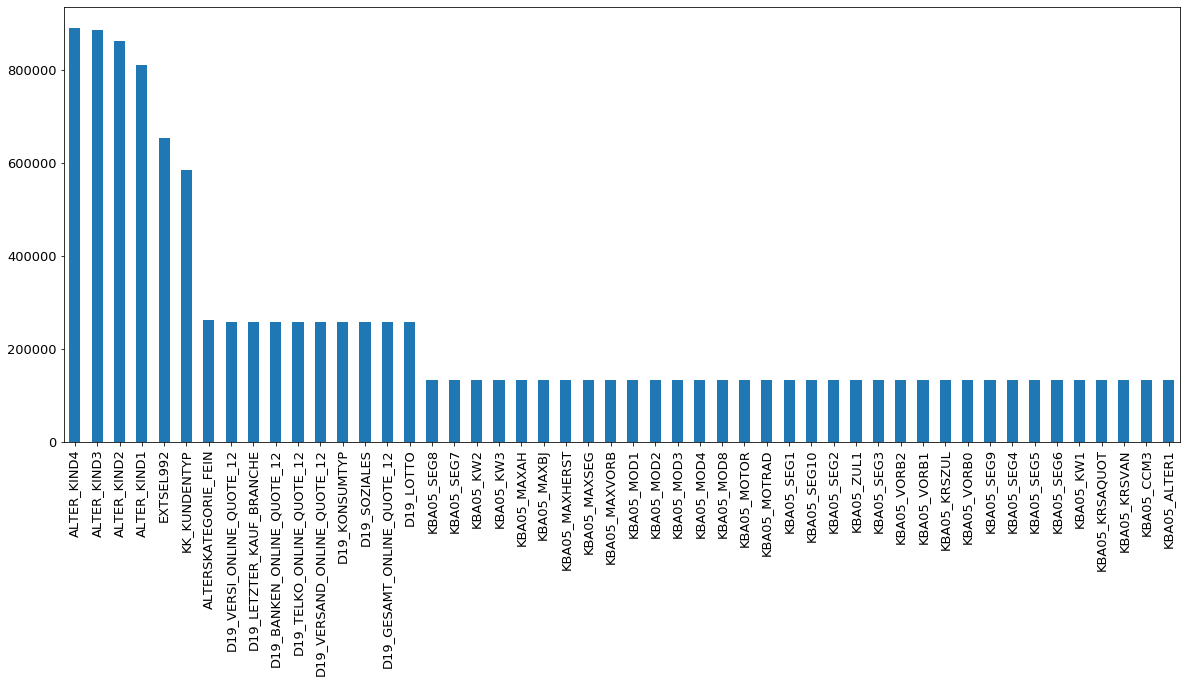

In [15]:
#plot missing/null data
(azdias_null_sum.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))

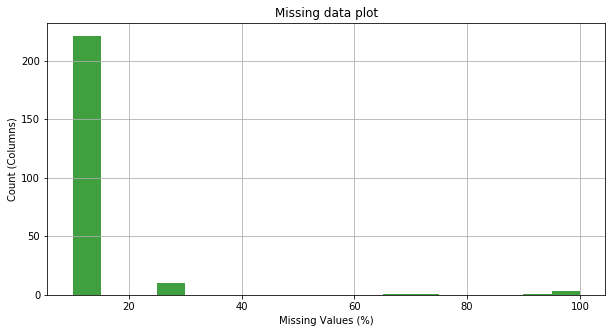

missing values in data 
 ALTER_KIND4               99.864792
ALTER_KIND3               99.307691
ALTER_KIND2               96.690047
ALTER_KIND1               90.904837
EXTSEL992                 73.399639
                            ...    
D19_VERSI_ONLINE_DATUM     0.000000
D19_VERSICHERUNGEN         0.000000
D19_VOLLSORTIMENT          0.000000
D19_WEIN_FEINKOST          0.000000
Unnamed: 0                 0.000000
Length: 367, dtype: float64


In [16]:
# plot proportionof missing values
plt.figure(figsize=(10,5))
plt.hist(azdias_null_ratio, bins = np.linspace(10,100,19), facecolor='g', alpha=0.75)

plt.xlabel('Missing Values (%)')
plt.ylabel('Count (Columns)')
plt.title('Missing data plot')
plt.grid(True)

plt.show()

# missing values in data
print('missing values in data','\n',azdias_null_ratio.sort_values(ascending=False))

#### Evaluate Missing Data in Rows

Let's analyse how much data is missing in each row of the dataset.

Text(0.5, 0, 'Missing values')

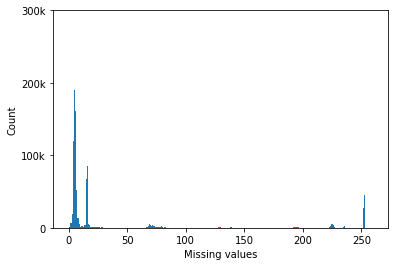

In [17]:
azdias_row_nulls = azdias[azdias.isnull().sum(axis=1) > 0].isnull().sum(axis=1)
plt.hist(azdias_row_nulls, bins = np.arange(-0.5,azdias_row_nulls.max()+1,1))
plt.yticks(np.arange(0,300000+100000,100000),['0','100k','200k','300k'])
plt.ylabel('Count')
plt.xlabel('Missing values')

#### Massage Data

In [18]:
nan_columns = azdias.isnull().mean()

# anlyse the extent of outlier in the data
print('columns having  missing values: ')
print('>0% : ',len(azdias_null_ratio[azdias_null_ratio>0].index))
print('>10%: ',len(azdias_null_ratio[azdias_null_ratio>10].index))
print('>20%: ',len(azdias_null_ratio[azdias_null_ratio>20].index))
print('>30%: ',len(azdias_null_ratio[azdias_null_ratio>30].index))
print('>40%: ',len(azdias_null_ratio[azdias_null_ratio>40].index))
print('>60%: ',len(azdias_null_ratio[azdias_null_ratio>60].index))
print('>65%: ',len(azdias_null_ratio[azdias_null_ratio>65].index))
print('>80%: ',len(azdias_null_ratio[azdias_null_ratio>80].index))
print('>90%: ',len(azdias_null_ratio[azdias_null_ratio>90].index))


columns having  missing values: 
>0% :  273
>10%:  237
>20%:  16
>30%:  6
>40%:  6
>60%:  6
>65%:  6
>80%:  4
>90%:  4


In [19]:
azdias = azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)

# There are 6 columns of missing data in >65% of the data set
azdias_drop_cols = azdias.columns[nan_columns > 0.65]
print('Null data columns: ', azdias_drop_cols)
azdias.shape[0]

Null data columns:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


733227

In [20]:
# Pre-process Customers dataset: drop extra columns .
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [21]:
#Drop data on azdias dataset
print('azdias - Columns before drop: ', len(azdias.columns))
azdias = azdias.drop(azdias_drop_cols,axis=1)
print('azdias - Columns after drop: ', len(azdias.columns))

#Drop data on customers dataset
print('customers - Columns before drop:: ', len(customers.columns))
customers = customers.drop(azdias_drop_cols,axis=1)
print('customers - Columns after drop:: ', len(customers.columns))

print('# rows azdias: ',azdias.shape)
print('# rows customers: ',customers.shape)

azdias - Columns before drop:  367
azdias - Columns after drop:  361
customers - Columns before drop::  367
customers - Columns after drop::  361
# rows azdias:  (733227, 361)
# rows customers:  (191652, 361)


In [22]:
azdias = azdias.drop(['EINGEFUEGT_AM'],axis=1)
azdias = azdias.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers = customers.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers = customers.drop(['EINGEFUEGT_AM'],axis=1)

In [23]:
# find and remove columns with high correlations

#drop correlated columns on azdias    
cor_matrix = azdias.corr().abs()
upper_lim = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))

drop_cols = [column for column in upper_lim.columns if any(upper_lim[column] > .7)]

azdias = azdias.drop(drop_cols, axis=1)
print('# of azdias columns', len(azdias.columns))

#drop correlated columns on customers    
cor_matrix = customers.corr().abs()
upper_lim = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))

drop_cols = [column for column in upper_lim.columns if any(upper_lim[column] > .7)]

customers = customers.drop(drop_cols, axis=1)
print('# of customers columns', len(customers.columns))

print(azdias.shape)
print(customers.shape)

# of azdias columns 239
# of customers columns 257
(733227, 239)
(191652, 257)


#### Deal with Categorical data

In [24]:
# identify categorical columns

azdias_cols = azdias.columns
numerical_cols = azdias._get_numeric_data().columns

categorical_cols = list(set(azdias_cols) - set(numerical_cols))
print(categorical_cols)

['CAMEO_DEU_2015', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015']


In [25]:
# apply fillna to handle null data

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)


azdias[azdias.columns[(azdias==9).any()]] = azdias[azdias.columns[(azdias==9).any()]].fillna(9)
customers[customers.columns[(customers==9).any()]] = customers[customers.columns[(customers==9).any()]].fillna(9)

azdias[azdias.columns[(azdias==0).any()]] = azdias[azdias.columns[(azdias==0).any()]].fillna(0)
customers[customers.columns[(customers==0).any()]] = customers[customers.columns[(customers==0).any()]].fillna(0)

azdias[azdias.columns[(azdias==-1).any()]] = azdias[azdias.columns[(azdias==-1).any()]].fillna(-1)
customers[customers.columns[(customers==-1).any()]] = customers[customers.columns[(customers==-1).any()]].fillna(-1)

In [26]:
# Apply one hot encoding

azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

In [27]:
print(azdias.columns)

Index(['Unnamed: 0', 'LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH',
       'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_KINDER', 'ANZ_PERSONEN',
       ...
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=285)


In [28]:
print(customers.columns)

Index(['Unnamed: 0', 'LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH',
       'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_KINDER', 'ANZ_PERSONEN',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_-1', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=304)


In [29]:
# use mode to assign nan values

gen_imputer = Imputer

azdias = gen_imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias)
print('azdias: ', azdias.head(5))

customers = gen_imputer.fit_transform(customers)
customers = pd.DataFrame(customers)
print('customers: ', customers.head(5))

customers = customers.astype(int)
azdias = azdias.astype(int)


print('azdias shape: ',azdias.shape)
print('customers shape: ',customers.shape)

azdias:     0         1    2    3     4     5     6    7    8    9    ...  275  276  \
0  1.0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  ...  0.0  0.0   
1  2.0  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0  ...  0.0  0.0   
2  3.0  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0  ...  0.0  0.0   
3  4.0  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0  ...  0.0  0.0   
4  5.0  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0  ...  1.0  0.0   

   277  278  279  280  281  282  283  284  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 285 columns]
customers:     0         1    2    3     4     5    6    7    8    9    ...  294  295  \
0  0.0    9626.0  2.0  1.0  10.0  10.0  1.0  0.0  0.0  2.0  ...  0.0  0.0   
1  1.0    9628.0 -1.0  9.0  11.0   9.0  9.0  9.0  0.0  3.0  ...  0.0

#### Manage outliers

In [30]:
# find and remove rows with outliers

azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]
print(azdias.head())
print(customers.head())

   0       1    2    3    4    5    6    7    8    9    ...  275  276  277  \
1    2  910225   -1    9   17   17   10    0    0    1  ...    0    0    0   
3    4  910241   -1    1   20   14    3    0    0    4  ...    0    0    0   
4    5  910244    3    1   10   10    5    0    0    1  ...    1    0    0   
5    6  910248   -1    9    0    9    4    0    0    1  ...    0    0    0   
6    7  910261   -1    1   14   14    6    0    0    1  ...    0    0    0   

   278  279  280  281  282  283  284  
1    0    0    0    0    0    0    1  
3    0    0    0    0    0    0    1  
4    0    0    0    0    0    0    1  
5    0    0    0    0    0    0    1  
6    0    0    0    0    0    0    1  

[5 rows x 285 columns]
    0       1    2    3    4    5    6    7    8    9    ...  294  295  296  \
1     1    9628   -1    9   11    9    9    9    0    3  ...    0    0    0   
3     3  143873    1    1    8    8    0    9    0    0  ...    0    0    0   
7     7  143910    1    1   10    9 

In [31]:
scaler = StandardScaler(copy=False)

azdias[azdias.columns] = scaler.fit_transform(azdias)
customers[customers.columns] = scaler.fit_transform(customers)

azdias.to_pickle('azdias_scaled')
customers.to_pickle('customers_scaled')

### Data Cleaning Function

Create a cleaning function to clean, recode and filter the dataset

In [32]:
def clean_data(df, cluster, dataset=None):
    
    if cluster:
        if dataset == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        
        
    
    cols_drop = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
    
    df = df.drop(cols_drop,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


       
    cor_mat = df.corr().abs()
    upper_lim = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
    
    drop_cols = [column for column in upper_lim.columns if any(upper_lim[column] > .7)]
    
    df = df.drop(drop_cols, axis=1)
    print('after correlation', df.shape)


    
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    df = pd.get_dummies(df)
    print('after encoding', df.shape)
    
    df_columns = list(df.columns.values)

    gen_imputer = Imputer
    df = gen_imputer.fit_transform(df)
    df = pd.DataFrame(df)
    print('after impute', df.shape)
    
    df = df.astype(int)


    if cluster:
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('before scaling', df.shape)
    
    scaler = StandardScaler(copy=False)
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('after scaling', df.shape)
    
    df = df.set_index('LNR')
    return df

In [33]:
# process customers data
customers = clean_data(original_customers, True, 'customers')
print(customers.shape)
print(customers.head(5))

# process azdias data
azdias = clean_data(original_azdias, True, 'azdias')
print(azdias.shape)
print(azdias.head(5))


after correlation (191652, 257)
after encoding (191652, 304)
after impute (191652, 304)
before scaling (100341, 304)
after scaling (100341, 304)
(100341, 303)
           Unnamed: 0  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                                           
-1.556361   -1.732271 -0.738505    1.010105  0.168897             -0.209002   
 0.872952   -1.732235  0.777112   -1.037635 -0.468300             -0.545546   
 0.873622   -1.732163  0.777112   -1.037635 -0.043502             -0.209002   
 0.118344   -1.732127  0.777112   -1.037635  2.080488              1.137176   
 0.118561   -1.732090  0.777112   -1.037635 -0.043502              0.127543   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                      
-1.556361             0.808794      0.992832   -0.193253     -0.686881   
 0.872952            -1.330334      0.992832   -0.193253     -1.5

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA

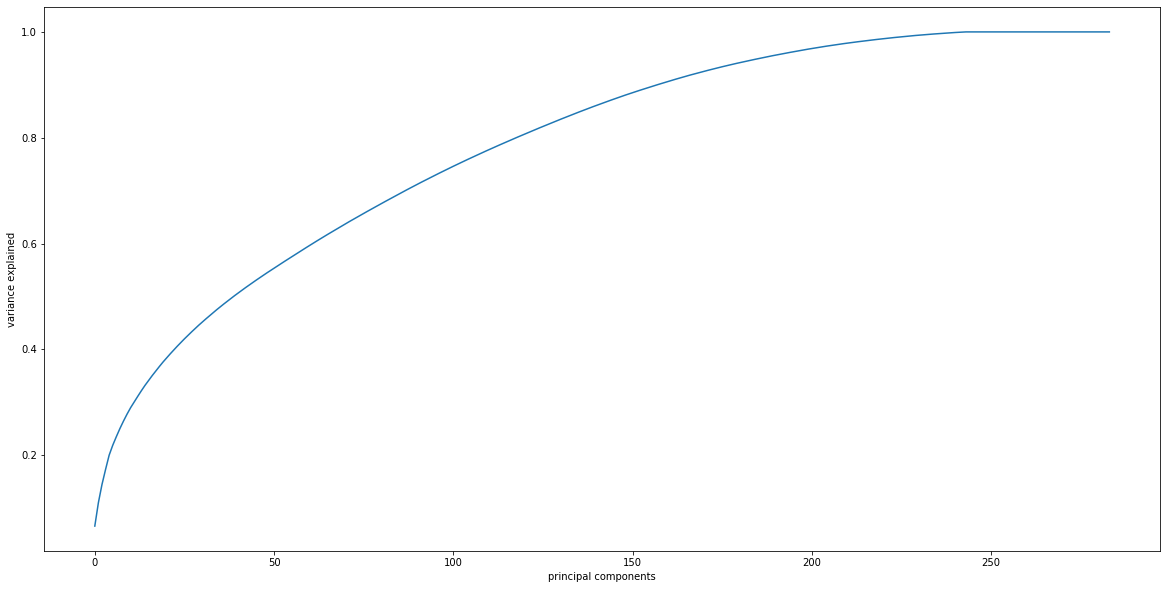

In [34]:
azdias_pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(azdias_pca.explained_variance_ratio_))
plt.xlabel('principal components')
plt.ylabel('variance explained')
plt.show()

In [35]:
def comp_adj(df,n=220):
    pca = PCA(n_components=n).fit(df)
    df_trans = pca.transform(df)
    df_trans = pd.DataFrame(df_trans)
    print(pca.explained_variance_ratio_.sum())
    return df_trans

In [36]:
azdias_adjusted = comp_adj(azdias)
azdias_adjusted.to_pickle('reduced_azdias.p')

customers_adjusted = comp_adj(customers)
customers_adjusted.to_pickle('reduced_customers.p')

0.9862763929632457
0.9972068419211809


In [37]:
##########
pca = PCA()
azdias_pca = pca.fit_transform(azdias)

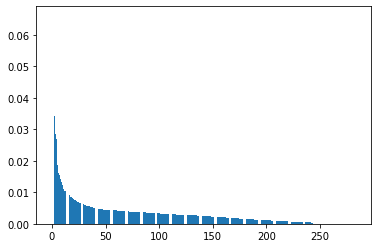

In [38]:
# variance investigation on each principal component.
comp=len(pca.explained_variance_ratio_)
comp_vals = np.arange(comp)
comp_ratio = pca.explained_variance_ratio_
plt.bar(comp_vals, comp_ratio)
plt.show()

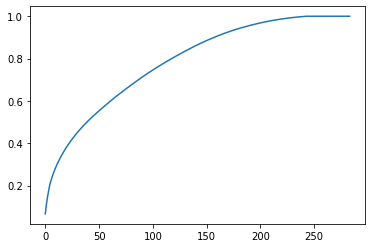

In [39]:
cum_vals = np.cumsum(comp_ratio)
plt.plot(cum_vals)
plt.show()

In [40]:
thresh = .90
i = np.argmax(cum_vals > thresh)
print(i, cum_vals[i])

157 0.9002898733226536


In [41]:
pca = PCA(i)
azdias_pca = pca.fit_transform(azdias)

In [42]:
# a function to easily Map weights and print the linked values.

def map_weights(features, components, i):
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    print('Lowest:')
    for feature, weight in feature_weights_sorted[:3]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        
    print('Highest:')
    for feature, weight in feature_weights_sorted[-3:]:
        print('\t{:20} {:.3f}'.format(feature, weight))

In [43]:
# PCA component 1
i = 0
print('{:5.2%}'.format(comp_ratio[i]))
map_weights(azdias.columns.values, pca.components_, i)

6.58%
Lowest:
	CAMEO_DEUG_2015      -0.187
	CAMEO_INTL_2015      -0.183
	HH_EINKOMMEN_SCORE   -0.175
Highest:
	MOBI_RASTER          0.163
	KBA13_ANTG1          0.172
	KBA05_ANTG1          0.172


In [44]:
# PCA component 2
i = 1
print('{:5.2%}'.format(comp_ratio[i]))
map_weights(azdias.columns.values, pca.components_, i)

4.42%
Lowest:
	KBA13_SEG_OBEREMITTELKLASSE -0.197
	KBA13_BMW            -0.191
	KBA13_SITZE_4        -0.177
Highest:
	KBA13_HERST_ASIEN    0.146
	OST_WEST_KZ_O        0.150
	KBA13_KMH_140_210    0.163


In [45]:
# PCA component 3
i = 2
print('{:5.2%}'.format(comp_ratio[i]))
map_weights(azdias.columns.values, pca.components_, i)

3.43%
Lowest:
	CJT_TYP_6            -0.232
	CJT_KATALOGNUTZER    -0.217
	RETOURTYP_BK_S       -0.180
Highest:
	SEMIO_PFLICHT        0.216
	ALTERSKATEGORIE_FEIN 0.216
	CJT_TYP_1            0.252


### Cluster Analysis

In [46]:
def score(data, k):
    kmeans_k = KMeans(k)
    k_model = kmeans_k.fit(data)
    return abs(k_model.score(data))

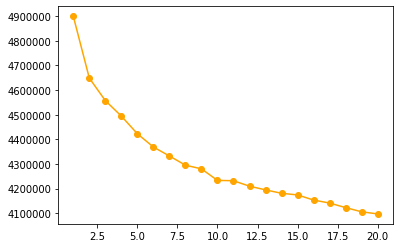

In [47]:
score_val = []
for i in range(1, 21):
    score_val.append(score(azdias_adjusted.sample(20000), i))
x = np.linspace(1,20,20)
plt.plot(x, score_val, linestyle='-', marker='o', color='orange')

Text(0.5, 0, 'Clusters Count')

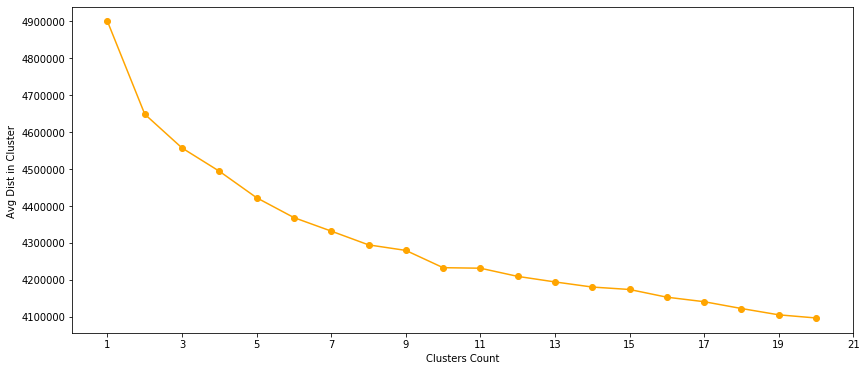

In [48]:
x = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(x, score_val, linestyle='-', marker='o', color='orange')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Avg Dist in Cluster ')
plt.xlabel('Clusters Count')

Using the chart above we can see that the the average distance within clusters starts getting flat as we approach 12 clusters. Informing the k value for our kmeans algorithm as 12.

In [49]:
k_means = KMeans(12)
k_model = k_means.fit(azdias_adjusted)
azdias_prediction = k_model.predict(azdias_adjusted)

In [50]:
azdias_cluster = pd.DataFrame(azdias_prediction, columns = ['Cluster'])
azdias_cluster.to_pickle('azdias_cluster')

In [51]:
customers_prediction = k_model.predict(customers_adjusted)
customers_cluster = pd.DataFrame(customers_prediction, columns = ['Cluster'])
customers_cluster.to_pickle('customers_cluster')

In [52]:
# Get the prediction count for all segments of customers 
 
customer_clusters_pred = pd.Series(customers_prediction)
customer_clusters_count = customer_clusters_pred.value_counts().sort_index()

population_clusters_pred = pd.Series(azdias_prediction)
population_clusters_count = population_clusters_pred.value_counts().sort_index()


df_segments = pd.concat([population_clusters_count, customer_clusters_count], axis=1).reset_index()
df_segments.columns = ['cluster','population','customer']

df_segments['difference'] = (df_segments['customer']/df_segments['customer'].sum()*100) - (df_segments['population']/df_segments['population'].sum()*100)
df_segments

,cluster,population,customer,difference
0,0,43233,2296,-8.119236
1,1,23715,1217,-4.496022
2,2,35466,171,-8.367273
3,3,39204,22926,13.410551
4,4,35875,13736,5.053169
5,5,31312,45027,37.336276
6,6,45215,11705,0.780663
7,7,53071,24,-12.751806
8,8,52212,799,-11.772654
9,9,18413,56,-4.376732


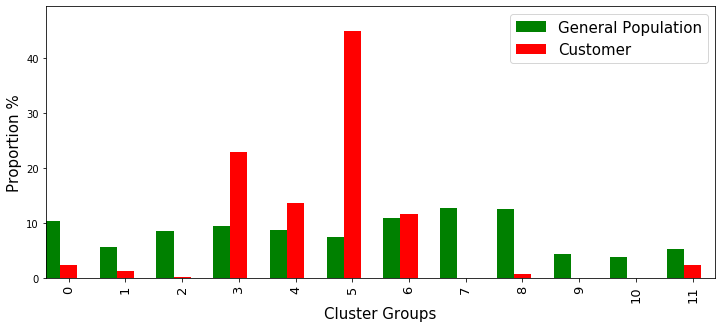

In [53]:
# proportion of customer segment data to general population.

df_segments['pop_percent'] = (df_segments['population']/df_segments['population'].sum()*100).round(2)
df_segments['cust_percent'] = (df_segments['customer']/df_segments['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

seg = fig.add_subplot(111)
seg = df_segments['pop_percent'].plot(x=df_segments['cluster'],width=-0.3,align='edge',color='green',kind='bar',position=0)
seg = df_segments['cust_percent'].plot(kind='bar',color='red',width = 0.3, align='edge',position=1)
seg.set_xlabel('Cluster Groups', fontsize=15) 
seg.set_ylabel('Proportion %', fontsize=15)
seg.xaxis.set(ticklabels=range(20))
seg.tick_params(axis = 'x', which = 'major', labelsize = 13)
seg.margins(x=0.5,y=0.1)

plt.legend(('General Population', 'Customer'),fontsize=15)

plt.show()

Cluster 7 shows an over respresentation of Customers. Lets see the highest positives and lowest negative weights for cluster 7



In [54]:
def principal_component_weights(pc,weight_num):
    
    prop = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    prop = prop.round(3)
    weight = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weight = weight.round(3)    
    
    result = pd.concat([prop, weight], axis = 1)
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [55]:
principal_component_weights(5,3)

Principal Component:  5


Highest Positive weights:
KBA13_KMH_210          0.223
OST_WEST_KZ_O          0.187
KBA13_CCM_1401_2500    0.183
Name: 4, dtype: float64


Negative weights:
KBA13_KW_0_60      -0.239
KBA13_KMH_180      -0.196
KBA13_CCM_0_1400   -0.194
Name: 4, dtype: float64


Cluster 10 shows an under respresentation of Customers. Lets see the highest positives and lowest negative weights for cluster 10

In [56]:
principal_component_weights(10,3)

Principal Component:  10


Highest Positive weights:
KBA05_MAXSEG     0.272
KBA05_KRSOBER    0.208
KBA05_CCM3       0.186
Name: 9, dtype: float64


Negative weights:
KBA05_CCM1      -0.235
KBA05_MODTEMP   -0.210
KBA05_HERST3    -0.162
Name: 9, dtype: float64


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [57]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('MAILOUT_TRAIN.csv', sep=';')

mailout_train.shape

C:\Users\Peter.Evah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42962, 368)

In [58]:
##################################################################################

In [59]:
mailout_train_lnr = mailout_train.LNR

#le = preprocessing.LabelEncoder()
#mailout_train = mailout_train.apply(le.fit_transform)

y = mailout_train.RESPONSE
X = mailout_train.drop(['RESPONSE', 'LNR'], axis=1)
X.shape

(42962, 366)

In [60]:
def process_columns(df_cols, features_info):
    
    numerical_cols = features_info[features_info.type == 'numeric'].index
    numerical_cols = set(numerical_cols).intersection(set(df_cols))
    
    categorical_cols = set(df_cols).difference(numerical_cols)

    return list(numerical_cols), list(categorical_cols)

In [61]:
def create_pre_processor(numerical, categorical):
    
    numerical_pipe = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler())
    
    categorical_pipe = make_pipeline(
        SimpleImputer(strategy='most_frequent'))
    
    pre_processor = ColumnTransformer(
        [('numerical_preprocessing', numerical_pipe, numerical),
         ('categorical_preprocessing', categorical_pipe, categorical)],
        remainder='drop')
    
    return pre_processor

In [62]:
# read in feature information
features_info = pd.read_csv('feat.csv')
features_info.set_index('attribute', inplace=True)

# Create the pre_processor
numerical_feat, categorical_feat = process_columns(X.columns, features_info)
pre_processor = create_pre_processor(numerical_feat, categorical_feat)


Xprocessed = pre_processor.fit_transform(X.astype(str))

print (numerical_feat)

cols = numerical_feat + categorical_feat 

['ANZ_KINDER', 'MIN_GEBAEUDEJAHR', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_TITEL', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'GEBURTSJAHR']


In [63]:
#################################################################################################

In [64]:
X_train = mailout_train.drop('RESPONSE',axis=1)
y_train = mailout_train['RESPONSE']

X_train_clean  = clean_data(X_train, False)

after correlation (42962, 254)
after encoding (42962, 301)
after impute (42962, 301)
after scaling (42962, 301)


In [65]:
#----------------------------------------------------------------------------------------------

### Gradient Boosting Classifier

In [66]:
gb_clf = GradientBoostingClassifier()
gb_clf.get_params()

param = {'learning_rate': [.001],
              'max_depth': [5],
              'random_state': [42]}


grid_s = GridSearchCV(estimator=gb_clf, param_grid=param, scoring='roc_auc', cv=5, n_jobs = 3)
grid_s.fit(X_train_clean, y_train)



print(grid_s.best_score_)
print(grid_s.best_estimator_)




0.7142099720252466
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [67]:
pickle.dump(grid_s.best_estimator_, open('gb_model.pkl', 'wb'))

### Adaptive Boosting Classifier

In [68]:
clf = AdaBoostClassifier(DecisionTreeClassifier())
clf.get_params()

param_grid = {'learning_rate': [0.1],
              'n_estimators':[50],
              'random_state': [42],
              'base_estimator__max_depth': [1, 3],
              'base_estimator__max_features': [20, None]}

ada = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs = 3)
ada_result =  ada.fit(X_train_clean, y_train)


print(ada.best_score_)
print(ada.best_estimator_)

0.7693249647068768
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
       

In [69]:
means = ada_result.cv_results_['mean_test_score']
stds = ada_result.cv_results_['std_test_score']
params = ada_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

pickle.dump(ada.best_estimator_, open('ada_model.pkl', 'wb'))

0.708511 (0.015691) with: {'base_estimator__max_depth': 1, 'base_estimator__max_features': 20, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
0.769325 (0.020776) with: {'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
0.657844 (0.032124) with: {'base_estimator__max_depth': 3, 'base_estimator__max_features': 20, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
0.707599 (0.024103) with: {'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}


### XGBoost Regressor

In [70]:
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X_train_clean, y_train, stratify=y, test_size=0.2, random_state=42)

xgb = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xgb.fit(X_train_xg,y_train_xg)

predictions = xgb.predict(X_test_xg)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_test_xg, predictions)))

[19:18:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
ROC score on validation data: 0.5000


In [71]:
pickle.dump(xgb, open('xgb_model.pkl', 'wb'))


From the above analysis, it is clear that the Adaptive Boosting Classifier (with 76% accuracy) gives better predictions than the other 2 classifiers (Gradient Boost - 71% and XGBoost - 50%). 

### Model Prediction

Lets test out the models on the sample test data set MAILOUT_TEST.csv

In [72]:
def pred_result(model, test, lnr):
    predictions = model.predict_proba(test)
    res = pd.DataFrame({'LNR':lnr, 'RESPONSE':predictions[:,0]})
    return res

In [74]:
mailout_test = pd.read_csv('MAILOUT_TEST.csv', sep=';')
print(mailout_test.shape)
lnr = mailout_test.LNR


(42833, 367)


In [75]:
# Clean up data

mailout_test_processed  = clean_data(mailout_test, False)

after correlation (42833, 254)
after encoding (42833, 301)
after impute (42833, 301)
after scaling (42833, 301)


In [76]:
# Gradient Boost
gb_model = joblib.load('gb_model.pkl')
predictions = gb_model.predict_proba(mailout_test_processed)
res = pd.DataFrame({'LNR':lnr, 'RESPONSE':predictions[:,0]})
res.to_csv('gb_predictions.csv', index=False)
res.head()


,LNR,RESPONSE
0,1754,0.985881
1,1770,0.985881
2,1465,0.988651
3,1470,0.988651
4,1478,0.988230


In [77]:
# AdaBoost
ada_model = joblib.load('ada_model.pkl')
res = pred_result(ada_model, mailout_test_processed, lnr)
res.to_csv('ada_predictions.csv', index=False)
res.head()

,LNR,RESPONSE
0,1754,0.665770
1,1770,0.672795
2,1465,0.720821
3,1470,0.733366
4,1478,0.733366


In [78]:
xgb_model = joblib.load('xgb_model.pkl')
predictions = xgb_model.predict(mailout_test_processed)
res = pd.DataFrame({'LNR':lnr, 'RESPONSE':predictions})
res.to_csv('xgb_predictions.csv', index=False)
res.head()

,LNR,RESPONSE
0,1754,0.182607
1,1770,0.182607
2,1465,0.182607
3,1470,0.182607
4,1478,0.182607


### Conclusion

In the Customer Segmentation Report part, We caried out data pre-processing and used Principal component analysis (PCA) to compute the principal components and used them to perform a change of basis on the data, this led to the selection of a few principal components for our model.

We also used the K-means clustering to partition the data into 12 clusters in a way that data points in the same cluster are similar and data points in the different clusters are farther apart. This enabled us obtain the clustering of different population. By this we were able to differentiate potential customer population from non-potential customer population. With this understanding, a company can better tell their target audience, and increase conversion rate or reduce their marketing/promotion cost.

The final part focused on building a model for predicting individuals that are more likely to respond and potentially become the company customers using the mailout campaign. Gradient Boosting, Adaptive Boosting and XGBoost classifiers were evaluated and AdaBoost was selected because it gave better results.


#### Improvement

Increase PCA components can help improve the results.
Using only the PCA components as independent variables.

It will also be helpful to have a clearer understanding of the features in order to determine the features to drop or re-engineer since the data dictionary does not include all columns 